In [2]:
import sys
import math
import numpy as np
import json
sys.path.insert(0, '..')
from net_framework import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

### Formatting Data

In [5]:
term_data = pd.read_csv('term.txt', sep="\t", header=None)
term_data.columns = ["#Lnum", "#snum", "#cnum", "Term Abbrev"]
term_data.head()

,#Lnum,#snum,#cnum,Term Abbrev
0,1,1,1,LB
1,1,1,2,LB
2,1,1,3,LE
3,1,1,4,WK
4,1,1,5,LF


In [6]:
term_data['#Lnum'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110])

In [7]:
cnum_data = pd.read_csv('cnum-vhcm-lab-new.txt', sep="\t")
locations = cnum_data[['#cnum']]
locations['Normalized-L'] = (cnum_data['L*'] - cnum_data['L*'].mean())/(cnum_data['L*'] - cnum_data['L*'].mean()).std() * 1/2
locations['Normalized-a'] = (cnum_data['a*'] - cnum_data['a*'].mean())/(cnum_data['a*'] - cnum_data['a*'].mean()).std() * 1/2
locations['Normalized-b'] = (cnum_data['b*'] - cnum_data['b*'].mean())/(cnum_data['b*'] - cnum_data['b*'].mean()).std() * 1/2
display(locations)

,#cnum,Normalized-L,Normalized-a,Normalized-b
0,141,0.853205,-0.025675,-0.138822
1,274,0.747664,-0.025504,-0.138822
2,129,0.747664,0.070445,-0.106039
3,230,0.747664,0.070101,-0.089951
4,302,0.747664,0.070617,-0.072041
...,...,...,...,...
325,305,-0.765518,0.567556,-0.362691
326,267,-0.765518,0.584752,-0.297579
327,243,-0.765518,0.593865,-0.235807
328,182,-0.765518,0.601603,-0.171302


In [8]:
# debug1 = cnum_data.loc[:, ['#cnum', 'L*', 'a*', 'b*']]
# debug1['L*'] = (debug1['L*'] - debug1['L*'].mean()) / debug1['L*'].std()
# debug1

In [9]:
locations = locations.sort_values('#cnum')
chip_num = list(locations['#cnum'])
lab_norm = [[row[2], row[3], row[4]] for row in locations.itertuples()]
# print(lab_norm)

In [10]:
# #Neural Network Shape Test
# NNtest = Neural_Network(inputSize = 3, outputSize = 9, hiddenSize = [3,3,3] , learning_rate = 0.001)
# NNtest(torch.FloatTensor([[1, 1, 1], [1, 1, 1]]))


In [11]:
language_num=5
l1 = term_data[term_data.get('#Lnum').eq(language_num)]
unique_symbols = list(l1['Term Abbrev'].unique())
l1_grouped = l1.groupby('#cnum')['Term Abbrev'].apply(list)
l1_chip_abbrev_percentage = [[(l1_grouped[i + 1].count(abbrev) / len(l1_grouped[i + 1])) \
                              for abbrev in unique_symbols] for i in range(len(l1_grouped))]
#display(l1_chip_abbrev_percentage)

In [12]:
l1_result = pd.DataFrame(l1_chip_abbrev_percentage)
l1_result.index += 1
l1_result.index.name = '#cnum'
l1_result.columns = unique_symbols
print(l1_result)
chip_norm = []
#pull the percentage for each cnum
for x in chip_num:
#     chip_norm.append((l1_result.loc[l1["#cnum"]==x]).values.tolist()[0])
    chip_norm.append(l1_result.loc[x,:].values.tolist())
#display(chip_norm)

              7         2    4         6         9         1         5    3  \
#cnum                                                                         
1      0.833333  0.166667  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
2      0.333333  0.666667  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
3      0.000000  0.000000  1.0  0.000000  0.000000  0.000000  0.000000  0.0   
4      0.000000  0.000000  0.0  1.000000  0.000000  0.000000  0.000000  0.0   
5      0.333333  0.666667  0.0  0.000000  0.000000  0.000000  0.000000  0.0   
...         ...       ...  ...       ...       ...       ...       ...  ...   
326    0.000000  0.000000  0.0  0.000000  0.000000  0.000000  1.000000  0.0   
327    0.166667  0.000000  0.0  0.000000  0.666667  0.000000  0.166667  0.0   
328    0.166667  0.666667  0.0  0.166667  0.000000  0.000000  0.000000  0.0   
329    0.000000  0.000000  0.0  0.333333  0.000000  0.166667  0.500000  0.0   
330    0.166667  0.000000  0.0  0.000000  0.833333  

### Defining Network Shapes

In [13]:
node_num = range(1,25)
layer_num = range(1,4)


shape_collection = []
for node in node_num:
    if node < 3:
        shape_collection.append([node])

def trickle(arr, iteration_left, check):
    if iteration_left == 0:
        global shape_collection
        #running the int fxn to make sure we don't have floats
        mp = map(int, arr)
        x = list(mp)
        if check == sum(x):
            shape_collection.append(x)
    else:
        new_arr = [0]+ arr + [0]
        #recursively expanding the list symmetrically
        while new_arr[0] < new_arr[1]-2 and new_arr[-1] < new_arr[-2]-2:
            new_arr[0] += 1
            new_arr[1] -= 1
            new_arr[-1] += 1
            new_arr[-2] -= 1
        trickle(new_arr, iteration_left - 1, check)

for node in node_num:
    for layer in layer_num:
        if node//layer < 3:
            continue
        if layer%2 == 0:
            trickle([node/2, node/2], (layer-2)/2, node)
        else:
            trickle([node], (layer-1)/2, node)      

print(shape_collection)


[[1], [2], [3], [4], [5], [6], [3, 3], [7], [8], [4, 4], [9], [3, 3, 3], [10], [5, 5], [3, 4, 3], [11], [3, 5, 3], [12], [6, 6], [4, 4, 4], [13], [4, 5, 4], [14], [7, 7], [4, 6, 4], [15], [5, 5, 5], [16], [8, 8], [5, 6, 5], [17], [5, 7, 5], [18], [9, 9], [6, 6, 6], [19], [6, 7, 6], [20], [10, 10], [6, 8, 6], [21], [7, 7, 7], [22], [11, 11], [7, 8, 7], [23], [7, 9, 7], [24], [12, 12], [8, 8, 8]]


### Training Network

In [14]:

#Number of training iterations
num_iters = 1000

#Listing out the shapes of each model
colors_num = len(chip_norm[0])
input_size = 3

network_shapes = []
for s in shape_collection:
    network_shapes.append((input_size,s,colors_num))

#Learning rate of the network
rate = 0.001

#Generating Training Data
def shuffle(lab_norm, chip_norm):
    '''
    Applying train-test split
    '''
    lab_train, lab_test, chip_train, chip_test = train_test_split(lab_norm, chip_norm, test_size=0.2, shuffle = True)
    input_train = torch.FloatTensor(lab_train)
    output_train = torch.FloatTensor(chip_train)
    input_test= torch.FloatTensor(lab_test)
    output_test = torch.FloatTensor(chip_test)
    return input_train, output_train, input_test, output_test

print(network_shapes)

[(3, [1], 9), (3, [2], 9), (3, [3], 9), (3, [4], 9), (3, [5], 9), (3, [6], 9), (3, [3, 3], 9), (3, [7], 9), (3, [8], 9), (3, [4, 4], 9), (3, [9], 9), (3, [3, 3, 3], 9), (3, [10], 9), (3, [5, 5], 9), (3, [3, 4, 3], 9), (3, [11], 9), (3, [3, 5, 3], 9), (3, [12], 9), (3, [6, 6], 9), (3, [4, 4, 4], 9), (3, [13], 9), (3, [4, 5, 4], 9), (3, [14], 9), (3, [7, 7], 9), (3, [4, 6, 4], 9), (3, [15], 9), (3, [5, 5, 5], 9), (3, [16], 9), (3, [8, 8], 9), (3, [5, 6, 5], 9), (3, [17], 9), (3, [5, 7, 5], 9), (3, [18], 9), (3, [9, 9], 9), (3, [6, 6, 6], 9), (3, [19], 9), (3, [6, 7, 6], 9), (3, [20], 9), (3, [10, 10], 9), (3, [6, 8, 6], 9), (3, [21], 9), (3, [7, 7, 7], 9), (3, [22], 9), (3, [11, 11], 9), (3, [7, 8, 7], 9), (3, [23], 9), (3, [7, 9, 7], 9), (3, [24], 9), (3, [12, 12], 9), (3, [8, 8, 8], 9)]


In [ ]:
#Array of losses over training period for each network
num_average = 10
output_file = {}
for n in node_num:
    output_file[n] = {}
    

for net_num, shape in enumerate(network_shapes):
    print("Training: ",shape)
    net_error_arr = []
    for j in range(num_average):
        print('Run ' + str(j+1))
        NN = Neural_Network(inputSize = shape[0], outputSize = shape[2],
                            hiddenSize = shape[1] , learning_rate = rate)
        error_arr = []
        prev_error = 0
        strike = 0

        input_train, output_train, input_test, output_test = shuffle(lab_norm, chip_norm)

        for i in range(num_iters):  
            NN.train(input_train, output_train)
            validation_error = NN.l1error(output_test, NN(input_test))
            #Printing error
            if i == 0: 
                dh = display("#" + str(i) + " Validation Error: " + str(validation_error), display_id=True)
            else:
                dh.update("#" + str(i) + " Validation Error: " + str(validation_error))
            
            #zero small error change
            if i == 0:
                strike = 0
            #adding error to array
            error_arr.append(validation_error)
            #waiting for number 'too small' decreases or increases in validation error before ending training
            if (prev_error < validation_error) and i > 100:
                if strike > 5:
                    print("Complete at iteration ", i, "\nFinal error: ", np.min(error_arr), "\n")
                    break
                else:
                    strike += 1
            prev_error = validation_error
        net_error_arr.append(np.min(error_arr))
    output_file[sum(shape[1])][len(shape[1])] = [np.mean(net_error_arr), np.std(net_error_arr)]

In [ ]:
with open('validation_errors.json', 'w') as f:
    json.dump(output_file, f)

### Looking at minimum size of networks for each threshold value

In [3]:
with open('validation_errors.json') as f:
    output_file=json.load(f)

(0.0, 0.2)

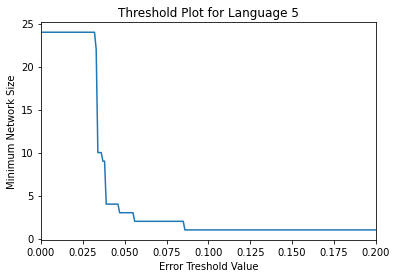

In [15]:
errors = []
for size in node_num:
    out_dict_for_size = output_file[str(size)]
    vals = list(out_dict_for_size.values())
    vals = np.array(vals)
    vals = vals[:,0]
    errors.append(np.min(vals))
errors = np.array(errors)

thresholds = np.arange(.001, 1, .001)

min_sizes = []
for threshold in thresholds:
    idx = 0
    for err in errors:
        if err <= threshold:
            break
        idx += 1
    if idx < len(node_num):
        min_sizes.append(node_num[idx])
    else:
        min_sizes.append(max(node_num))
        
plt.title('Threshold Plot for Language {0}'.format(language_num))
plt.plot(thresholds, min_sizes)
plt.xlabel('Error Treshold Value')
plt.ylabel('Minimum Network Size')
plt.xlim(0,0.2)

**Calculating Complexity in bits**

In [55]:
def language_complexity(lnum):
    language_data = term_data[term_data.get('#Lnum').eq(lnum)]
    unique_terms = list(language_data['Term Abbrev'].unique())
    l1_grouped = language_data.groupby('#cnum')['Term Abbrev'].apply(list)
    display(l1_grouped)
    l1_chip_abbrev_percentage = [[(l1_grouped[i + 1].count(abbrev) / len(l1_grouped[i + 1])) \
                              for abbrev in unique_terms] for i in range(len(l1_grouped))]
    l1_result = pd.DataFrame(l1_chip_abbrev_percentage)
    l1_result.index += 1
    l1_result.index.name = '#cnum'
    l1_result.columns = unique_terms

    chip_norm = []

    for x in chip_num:
        chip_norm.append(l1_result.loc[x,:].values.tolist())

    terms = unique_terms
    chips = list(language_data['#cnum'].unique())

    complexity = 0
    prior_m = 1 / len(chips)
    for w in terms:
        word_prob = 0
        for m in chips:
            word_prob += prior_m * l1_result.at[m, w]
        for m in chips:
            encoder_prob = l1_result.at[m, w]
            if encoder_prob != 0:
                mutual_information = prior_m * encoder_prob * np.log2(encoder_prob / word_prob)
            complexity += mutual_information

    return complexity

In [56]:
result = language_complexity(language_num)
print(result)

#cnum
1      [7, 7, 7, 7, 7, 2]
2      [2, 2, 7, 7, 2, 2]
3      [4, 4, 4, 4, 4, 4]
4      [6, 6, 6, 6, 6, 6]
5      [7, 2, 7, 2, 2, 2]
              ...        
326    [5, 5, 5, 5, 5, 5]
327    [7, 9, 9, 9, 5, 9]
328    [2, 2, 2, 7, 2, 6]
329    [1, 5, 5, 5, 6, 6]
330    [7, 9, 9, 9, 9, 9]
Name: Term Abbrev, Length: 330, dtype: object

9.803655245868127
